# Holistic Function
## Import package

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import hickle as hkl
import time
import datetime

from matplotlib.animation import FuncAnimation
import psutil
import collections
import os
from IPython.display import clear_output

import copy
import hashlib

import socket

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

## Hand 2D hand area function

In [2]:
# 计算2d三角形面积公式
def heron(a,b,c):  
    s = (a + b + c) / 2   
    area = (s*(s-a) * (s-b)*(s-c)) ** 0.5        
    return area

def distance2d(x1,y1,z1,x2,y2,z2):    
    a=(x1-x2)**2+(y1-y2)**2
    d= a ** 0.5  
    return d  

def areatriangle2d(x1,y1,z1,x2,y2,z2,x3,y3,z3):  
    a=distance2d(x1,y1,z1,x2,y2,z2)  
    b=distance2d(x2,y2,z2,x3,y3,z3)  
    c=distance2d(x3,y3,z3,x1,y1,z1)  
    A = heron(a,b,c)  
    print("area of triangle is %r " %A)
    
def areatriangle2d_By_Points(p1,p2,p3,w,h):  
    x1 = p1.x*w
    y1 = p1.y*h
    z1 = p1.z*w
    
    x2 = p2.x*w
    y2 = p2.y*h
    z2 = p2.z*w
    
    x3 = p3.x*w
    y3 = p3.y*h
    z3 = p3.z*w
    
#     z1 = 0
#     z2 = 0
#     z3 = 0
    a=distance2d(x1,y1,z1,x2,y2,z2)  
    b=distance2d(x2,y2,z2,x3,y3,z3)  
    c=distance2d(x3,y3,z3,x1,y1,z1)  
    A = heron(a,b,c)
    return A


def areatriangle2d_sum(hand_landmarks,w,h): 
    extract_point = [4,8,12,16,20,0]
    p = []
    for i in extract_point:
        p.append(hand_landmarks.landmark[i])
    a1 = areatriangle2d_By_Points(p[0],p[1],p[2],w,h)
    a2 = areatriangle2d_By_Points(p[0],p[2],p[3],w,h)
    a3 = areatriangle2d_By_Points(p[0],p[3],p[4],w,h)
    a4 = areatriangle2d_By_Points(p[0],p[4],p[5],w,h)
    
    a = a1+a2+a3+a4
    return a



## calculate arm angle

input is holistic body landmark

output is left and right angle by 2D point calculation

if the arm not shows up, return angle 0 for that arm.

In [3]:
def angle_calculate(holistic_landmarks,w,h): 
#     left/right three point
    arm_points = [11, 13, 15, 12, 14, 16]
    
    angle1 = -1
    angle2 = -1
    if holistic_landmarks:
        ldm = holistic_landmarks.landmark
        if ldm[arm_points[0]] and ldm[arm_points[1]] and ldm[arm_points[2]]:
            a1 = np.array([ldm[arm_points[0]].x*w ,ldm[arm_points[0]].y*h])
            b1 = np.array([ldm[arm_points[1]].x*w ,ldm[arm_points[1]].y*h])
            c1 = np.array([ldm[arm_points[2]].x*w ,ldm[arm_points[2]].y*h])

            ba1 = a1 - b1
            bc1 = c1 - b1

            cosine_angle1 = np.dot(ba1, bc1) / (np.linalg.norm(ba1) * np.linalg.norm(bc1))
            angle1 = np.arccos(cosine_angle1)/np.pi*180

        if ldm[arm_points[3]] and ldm[arm_points[4]] and ldm[arm_points[5]]:
            a2 = np.array([ldm[arm_points[3]].x*w ,ldm[arm_points[3]].y*h])
            b2 = np.array([ldm[arm_points[4]].x*w ,ldm[arm_points[4]].y*h])
            c2 = np.array([ldm[arm_points[5]].x*w ,ldm[arm_points[5]].y*h])

            ba2 = a2 - b2
            bc2 = c2 - b2

            cosine_angle2 = np.dot(ba2, bc2) / (np.linalg.norm(ba2) * np.linalg.norm(bc2))
            angle2 = np.arccos(cosine_angle2)/np.pi*180
    return [angle1, angle2]
    

## Holistic record data

Record hand , face, holistic 2.5D data in list and save. It will also calculate the hand area and arm angles of left and right.

In [4]:
# 按照 时间, index, 存储 坐标和图像信息, 读取并重新画图分析
# test the 2D area stable in the video stream
def hand_area_tracking_recording(filename): 

    now = datetime.datetime.now()
    now_ts = time.time()
    data_s = []
    index_s = []
    time_s = []
    result_s = []
    image_s = []
    image_size = []
    idx = 0
    
    face_data = []
    pose_data = []
    left_hand_data = []
    right_hand_data = []

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
#     mp_hands = mp.solutions.hands
    mp_holistic = mp.solutions.holistic
    
    POSE_CONNECTIONS = frozenset([(0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5),
                              (5, 6), (6, 8), (9, 10), (11, 12), (11, 13),
                              (13, 15),
                              (12, 14), (14, 16),
                              (11, 23), (12, 24), (23, 24), (23, 25),
                              (24, 26), (25, 27), (26, 28), (27, 29), (28, 30),
                              (29, 31), (30, 32), (27, 31), (28, 32)])


    hand_area_left = collections.deque(np.zeros(500))
    hand_area_right = collections.deque(np.zeros(500))
    arm_angle_left = collections.deque(np.zeros(500))
    arm_angle_right = collections.deque(np.zeros(500))
#     hand_z = collections.deque(np.zeros(500))

#     hand_z1 = collections.deque(np.zeros(500))
#     hand_z2 = collections.deque(np.zeros(500))
#     hand_z3 = collections.deque(np.zeros(500))
#     hand_z4 = collections.deque(np.zeros(500))

    cap = cv2.VideoCapture(0)
    with mp_holistic.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as holistic:
      while cap.isOpened():
        success, image = cap.read()
        ts = time.time()
        time_s.append(ts)
        if not success:
          # If loading a video, use 'break' instead of 'continue'.
            continue

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = holistic.process(image)
        
        image_height, image_width, _ = image.shape
        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        face_data.append(results.face_landmarks)
        pose_data.append(results.pose_landmarks)
        left_hand_data.append(results.left_hand_landmarks)
        right_hand_data.append(results.right_hand_landmarks)
        
        
        
        pose_landmarks_fix = results.pose_landmarks
        if pose_landmarks_fix is not None and results.left_hand_landmarks is not None and results.right_hand_landmarks is not None:
            pose_landmarks_fix.landmark[18].visibility = 0.1
            pose_landmarks_fix.landmark[20].visibility = 0.1
            pose_landmarks_fix.landmark[22].visibility = 0.1

            pose_landmarks_fix.landmark[17].visibility = 0.1
            pose_landmarks_fix.landmark[19].visibility = 0.1
            pose_landmarks_fix.landmark[21].visibility = 0.1

            pose_landmarks_fix.landmark[15].x = results.left_hand_landmarks.landmark[0].x
            pose_landmarks_fix.landmark[15].y = results.left_hand_landmarks.landmark[0].y
            pose_landmarks_fix.landmark[15].z = results.left_hand_landmarks.landmark[0].z
            pose_landmarks_fix.landmark[15].visibility = 1

            pose_landmarks_fix.landmark[16].x = results.right_hand_landmarks.landmark[0].x
            pose_landmarks_fix.landmark[16].y = results.right_hand_landmarks.landmark[0].y
            pose_landmarks_fix.landmark[16].z = results.right_hand_landmarks.landmark[0].z
            pose_landmarks_fix.landmark[16].visibility = 1

            
        mp_drawing.draw_landmarks(
             image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
             mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=4),
             mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2))
        mp_drawing.draw_landmarks(
             image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4),
             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=2))
        mp_drawing.draw_landmarks(
            image, pose_landmarks_fix, POSE_CONNECTIONS,
             mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=4),
             mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2))
        mp_drawing.draw_landmarks(
            image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
            mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

# calculate all necessary data than plot together
        scale_area = 1000.0
#         if results.left_hand_landmarks:
#             hand_area_left.popleft()
#             area = areatriangle2d_sum(results.left_hand_landmarks,image_width,image_height)
#             hand_area_left.append(area/scale_area)
#         else:
#             hand_area_left.popleft()
#             hand_area_left.append(0)
            
#         if results.right_hand_landmarks:
#             hand_area_right.popleft()
#             area = areatriangle2d_sum(results.right_hand_landmarks,image_width,image_height)
#             hand_area_right.append(area/scale_area)
#         else:
#             hand_area_right.popleft()
#             hand_area_right.append(0)
            
        ang = angle_calculate(results.pose_landmarks,image_width,image_height)
        arm_angle_left.popleft()
        arm_angle_left.append(ang[0])
        arm_angle_right.popleft()
        arm_angle_right.append(ang[1])
        
        clear_output(wait=True)
        
        
#         send angle data to device
# right arm
        name = 'angle_arm1'
        angle_right = ang[1]
        IP = '127.0.0.1'
        stp = ts
        udp_sender(name, angle_right, IP, stp)
        
#         left arm
#         name2 = 'angle_arm2'
#         angle_right2 = ang[0]
#         IP2 = '127.0.0.1'
#         stp = ts
#         udp_sender(name2, angle_right2, IP2, stp)
        
        
        
#         plt.subplot(221)
#         plt.plot(hand_area_left)
#         plt.title("Left hand area")
#         plt.xlabel("Time")
#         plt.ylabel("Hand area")
        
#         plt.subplot(222)
#         plt.plot(hand_area_right)
#         plt.title("Right hand area")
#         plt.xlabel("Time")
#         plt.ylabel("Hand area")

        plt.subplot(223)
        plt.plot(arm_angle_left)
        plt.title("Left arm angle")
        plt.xlabel("Time")
        plt.ylabel("Angle")
        
        plt.subplot(224)
        plt.plot(arm_angle_right)
        plt.title("Right arm angle")
        plt.xlabel("Time")
        plt.ylabel("Angle")
        
        plt.show()
            

#         if results.multi_hand_landmarks:
#           #     save data
#           index_s.append(idx)
#           time_s.append(ts)
#           result_s.append(results.multi_hand_landmarks)
# #           image_s.append(image)
#           for hand_landmarks in results.multi_hand_landmarks:
#             clear_output(wait=True)
#             hand_area.popleft()
#             hand_z.popleft()
#             area = areatriangle2d_sum(hand_landmarks,image_width,image_height)
#             hand_area.append(area/1000)
#             hand_z.append(hand_landmarks.landmark[4].z)


#             plt.plot(hand_area)
#             plt.title("Hand area tracking with time")
#             plt.xlabel("Time")
#             plt.ylabel("Hand area")
#             plt.show()
# #             output empty background not increase FPS
# #             image = np.zeros((image_height,image_width,_))
#             mp_drawing.draw_landmarks(
#                 image,
#                 hand_landmarks,
#                 mp_hands.HAND_CONNECTIONS,
#                 mp_drawing_styles.get_default_hand_landmarks_style(),
#                 mp_drawing_styles.get_default_hand_connections_style())
        # Flip the image horizontally for a selfie-view display.
        image = cv2.flip(image, 1)
        if len(time_s)>1:
            cv2.putText(image, "FPS: " + str(round(1.0 / (time_s[-1] - time_s[-2]),0)), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 255, 0), 2, )
        cv2.imshow('MediaPipe Holistic', image)
        idx = idx + 1
        if cv2.waitKey(5) & 0xFF == 27:
          break
    cap.release()
    cv2.destroyAllWindows()
    for i in range (1,5):
        cv2.waitKey(1)

    data_s.append(index_s)  
    data_s.append(time_s)
    
    result_s.append(face_data)
    result_s.append(pose_data)
    result_s.append(left_hand_data)
    result_s.append(right_hand_data)

    data_s.append(result_s) # when the lendmark is not null, store the result with
#     data_s.append(image_s)
    
    image_size.append(image_width)
    image_size.append(image_height)
    
    data_s.append(image_size)
    time_md5 = str(now.year) +'-'+str(now.month)+'-'+str(now.day)+ '-'+str(now.hour)+'-'+str(now.minute)+'-'+str(now.second)
    result_md5 = hashlib.md5(time_md5.encode())
    md5 = result_md5.hexdigest()
    fname = filename+'-'+md5+'_gzip.hkl'
    # 2015 5 6 8 53 40
    # Dump data, with compression
    hkl.dump(data_s, fname, mode='w', compression='gzip')
    print("data save success on: "+fname)
    tm_out = round((ts - now_ts),2)
    print("total time: " + str(tm_out)+' s')
    f_size = round(os.path.getsize(fname)/1048576,2)
    print("file size: " + str(f_size)+" MB")
    return data_s, fname

## Send UDP data

In [5]:
def angle_translation(angle):
    angle_ts = -1
    
    if angle >= 90:
        angle_ts = angle - 90
    elif angle >= 0 and angle < 90:
        angle_ts = angle - 90
    
    return angle_ts
    
    
def udp_sender(name, angle, IP, time):
#     print("UDP target IP:", UDP_IP)
#     print("UDP target port:", UDP_PORT)
#     print("message:", MESSAGE)
    
    UDP_IP = IP
    UDP_PORT = 5005
    angle_sd = angle_translation(angle)
    MESSAGE = name + ","+ str(angle_sd) + "," + "0" + "," + str(time)
    
    if angle > 45 and angle < 180:
        print(MESSAGE)
        sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # UDP
        sock.sendto(bytes(MESSAGE, "utf-8"), (UDP_IP, UDP_PORT))

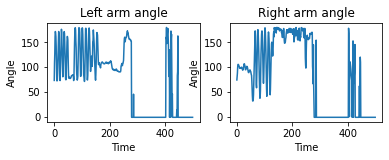

In [ ]:
filename = "Holistic_exoskeleton"
data_s1, fname1 = hand_area_tracking_recording(filename+'')